In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic

In [3]:
import vice

from surp import subgiants
from surp import gce_math as gcem
from surp.gce_math import MH_to_Z, Z_to_MH, Z_SUN
import surp

import arya

/users/PAS2232/aeyobd/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [4]:
from scipy.stats import t, norm


In [5]:
arya.style.set_size((4, 2*np.sqrt(2)))

In [6]:
surp.set_yields()

In [7]:
all_abundances = pd.read_csv("data_analysis/all_data.csv")
stars = pd.read_csv("../data/amarsi_19.tsv", delimiter="\t *", comment="#", skiprows=[62, 63], engine="python")
stars["C_MG"] =  stars["[C/H]3N"] - stars["[O/H]3N"]
stars["MG_H"] =  stars["[O/H]3N"]
stars["C_MG_ERR"] = stars["e_[C/H]3N"] + stars["e_[O/H]3N"]

df_stars = stars[["C_MG", "MG_H", "C_MG_ERR"]]

all_abundances["C_MG"] = all_abundances["[c/o]"]
all_abundances["MG_H"] = all_abundances["[o/h]"]
all_abundances["C_MG_ERR"] = all_abundances["[c/o]_err"]

stars_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "star")]
RL_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "RL")]
DLA_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "DLA")]
dwarf_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "dwarf")]

In [8]:
stars_x_obs = stars.MG_H
stars_y_obs = stars.C_MG
all_x_obs = all_abundances.MG_H
all_y_obs = all_abundances.C_MG

In [9]:

filt = ~subgiants.high_alpha.values
df = subgiants[filt]

bins = np.quantile(df.MG_H, np.linspace(0, 1, 20))

counts = binned_statistic(df.MG_H, df.C_MG, bins=bins, statistic='count')[0]

ym = binned_statistic(df.MG_H, df.C_MG, bins=bins, statistic='median')[0]
yl = binned_statistic(df.MG_H, df.C_MG, bins=bins, statistic=lambda x: np.percentile(x, 16))[0]
yh = binned_statistic(df.MG_H, df.C_MG, bins=bins, statistic=lambda x: np.percentile(x, 84))[0]
ym_err = binned_statistic(df.MG_H, df.C_MG_ERR, bins=bins, statistic='mean')[0]


xm = binned_statistic(df.MG_H, df.MG_H, bins=bins, statistic='median')[0]
xl = binned_statistic(df.MG_H, df.MG_H, bins=bins, statistic=lambda x: np.percentile(x, 16))[0]
xh = binned_statistic(df.MG_H, df.MG_H, bins=bins, statistic=lambda x: np.percentile(x, 84))[0]
xm_err = binned_statistic(df.MG_H, df.MG_H_ERR, bins=bins, statistic='mean')[0]

In [10]:
yym = gcem.brak_to_abund(ym, "c", "mg")
yyl = gcem.brak_to_abund(yl - ym_err, "c", "mg")
yyh = gcem.brak_to_abund(yh + ym_err, "c", "mg")
yym_err = (yyh - yyl) / 2 / np.sqrt(counts)

x_err = (xh - xl)/ 2 / np.sqrt(counts)

In [11]:
obs = (xm, yym, x_err, yym_err)

In [12]:
def plot_obs():
    plt.errorbar(xm, yym, yerr=yym_err, xerr=x_err,  fmt=".", capsize=0)

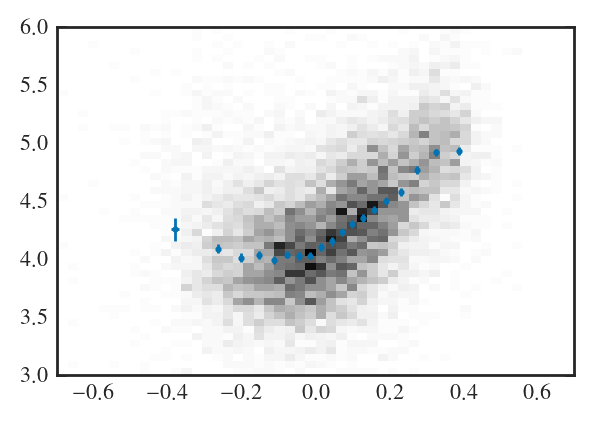

In [13]:
plt.hist2d(df.MG_H, gcem.brak_to_abund(df.C_MG, "c", "mg"), 50, range=([-0.7, 0.7], [3, 6]), cmap="Greys")
plot_obs()


# LS Fits

In [14]:
from scipy.optimize import curve_fit

In [15]:
def loglin(x, a, b):
    return a + b*x

In [16]:
popt, covt = curve_fit(loglin, xm, yym, sigma=yym_err)

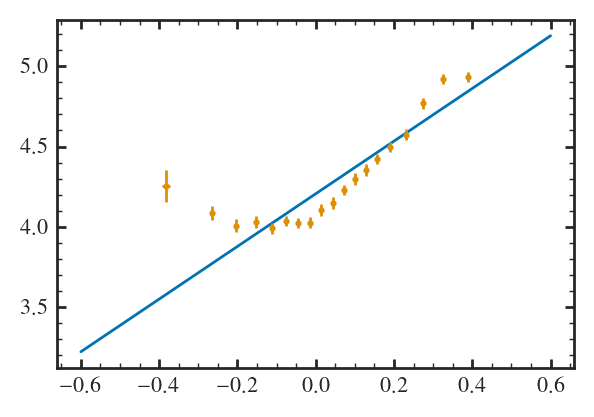

In [17]:
x_pred = np.linspace(-0.6, 0.6, 1000)
y_pred = loglin(x_pred, *popt)
plt.plot(x_pred, y_pred)
plot_obs()

In [18]:
def lin(x, a, b):
    Z = gcem.MH_to_Z(x)
    return a + b*(Z - Z_SUN)

In [19]:
popt, covt = curve_fit(lin, xm, yym, sigma=yym_err)

In [20]:
popt

array([ 4.15787404, 36.59623537])

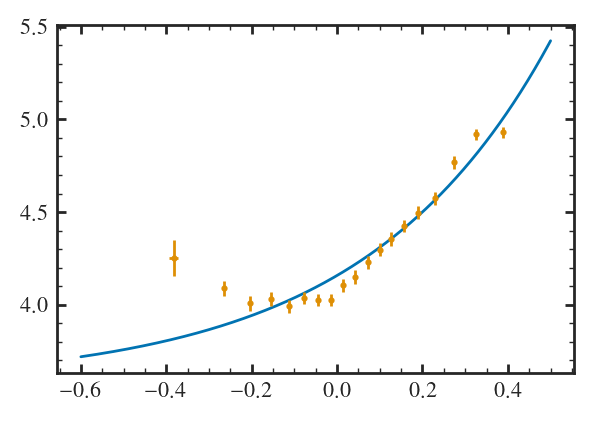

In [21]:
x_pred = np.linspace(-0.6, 0.5, 1000)
y_pred = lin(x_pred, *popt)
plt.plot(x_pred, y_pred)
plot_obs()

In [22]:
def logquad(x, a, b, c):
    return a + b*x + c*x**2

In [23]:
popt, covt = curve_fit(logquad, xm, yym, sigma=yym_err)

In [24]:
popt

array([4.12000938, 1.19517306, 3.16358275])

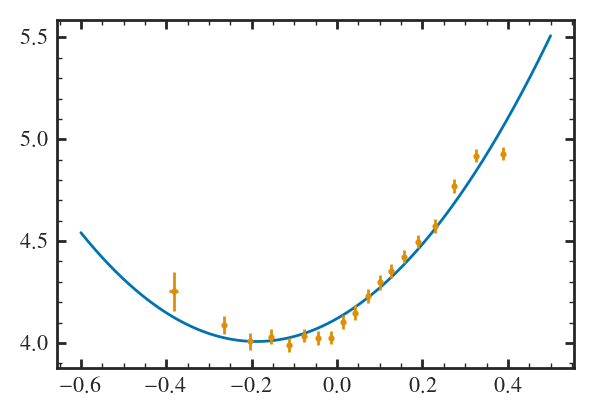

In [25]:
x_pred = np.linspace(-0.6, 0.5, 1000)
y_pred = logquad(x_pred, *popt)
plt.plot(x_pred, y_pred)
plot_obs()

# How do the stars work?

In [26]:
ymg = vice.yields.ccsne.settings["mg"]

In [27]:
def agb_model(m_h):
    return (2.85e-3 * 0.2 + -0.01 * (gcem.MH_to_Z(m_h) - Z_SUN)) / ymg

In [ ]:
x_pred = np.linspace(-2, 0.6, 1000)
y_pred = logquad(x_pred, *popt)

In [ ]:
plt.scatter(stars_x_obs, gcem.brak_to_abund(stars_y_obs, "c", "mg"))
plt.plot(x_pred, y_pred)
plt.plot(x_pred, y_pred - agb_model(x_pred))
plt.plot(x_pred, agb_model(x_pred))

plt.xlim(-2.5, 0.6)

# MCMC fits

In [30]:
import mcmc_utils

In [36]:
model = mcmc_utils.Linear(beta0=[4, 0.5], beta1=[0, 1], log_sigma=[-15, 0.5])



[[  3.80984039  -1.15782124 -15.60623276]
 [  4.16237669  -1.30670836 -15.00218833]
 [  3.94445586  -0.20513652 -15.15619077]
 [  4.28429484  -0.41233495 -15.07561114]
 [  4.02782386   0.23427424 -14.61950458]
 [  4.04742418  -0.1184334  -15.14395675]
 [  3.76916962   0.68886384 -14.98965078]
 [  3.84721391   0.79319885 -14.81321476]
 [  3.96415153  -2.4278714  -14.68194037]
 [  3.97252704  -0.0657203  -14.93442366]]


100%|██████████| 1000/1000 [00:11<00:00, 90.72it/s]


$\beta_0$ = 4.00 + 0.53 - 0.51
$\beta_1$ = 0.01 + 1.05 - 0.91
$\log(\sigma)$ = -15.04 + 0.48 - 0.51


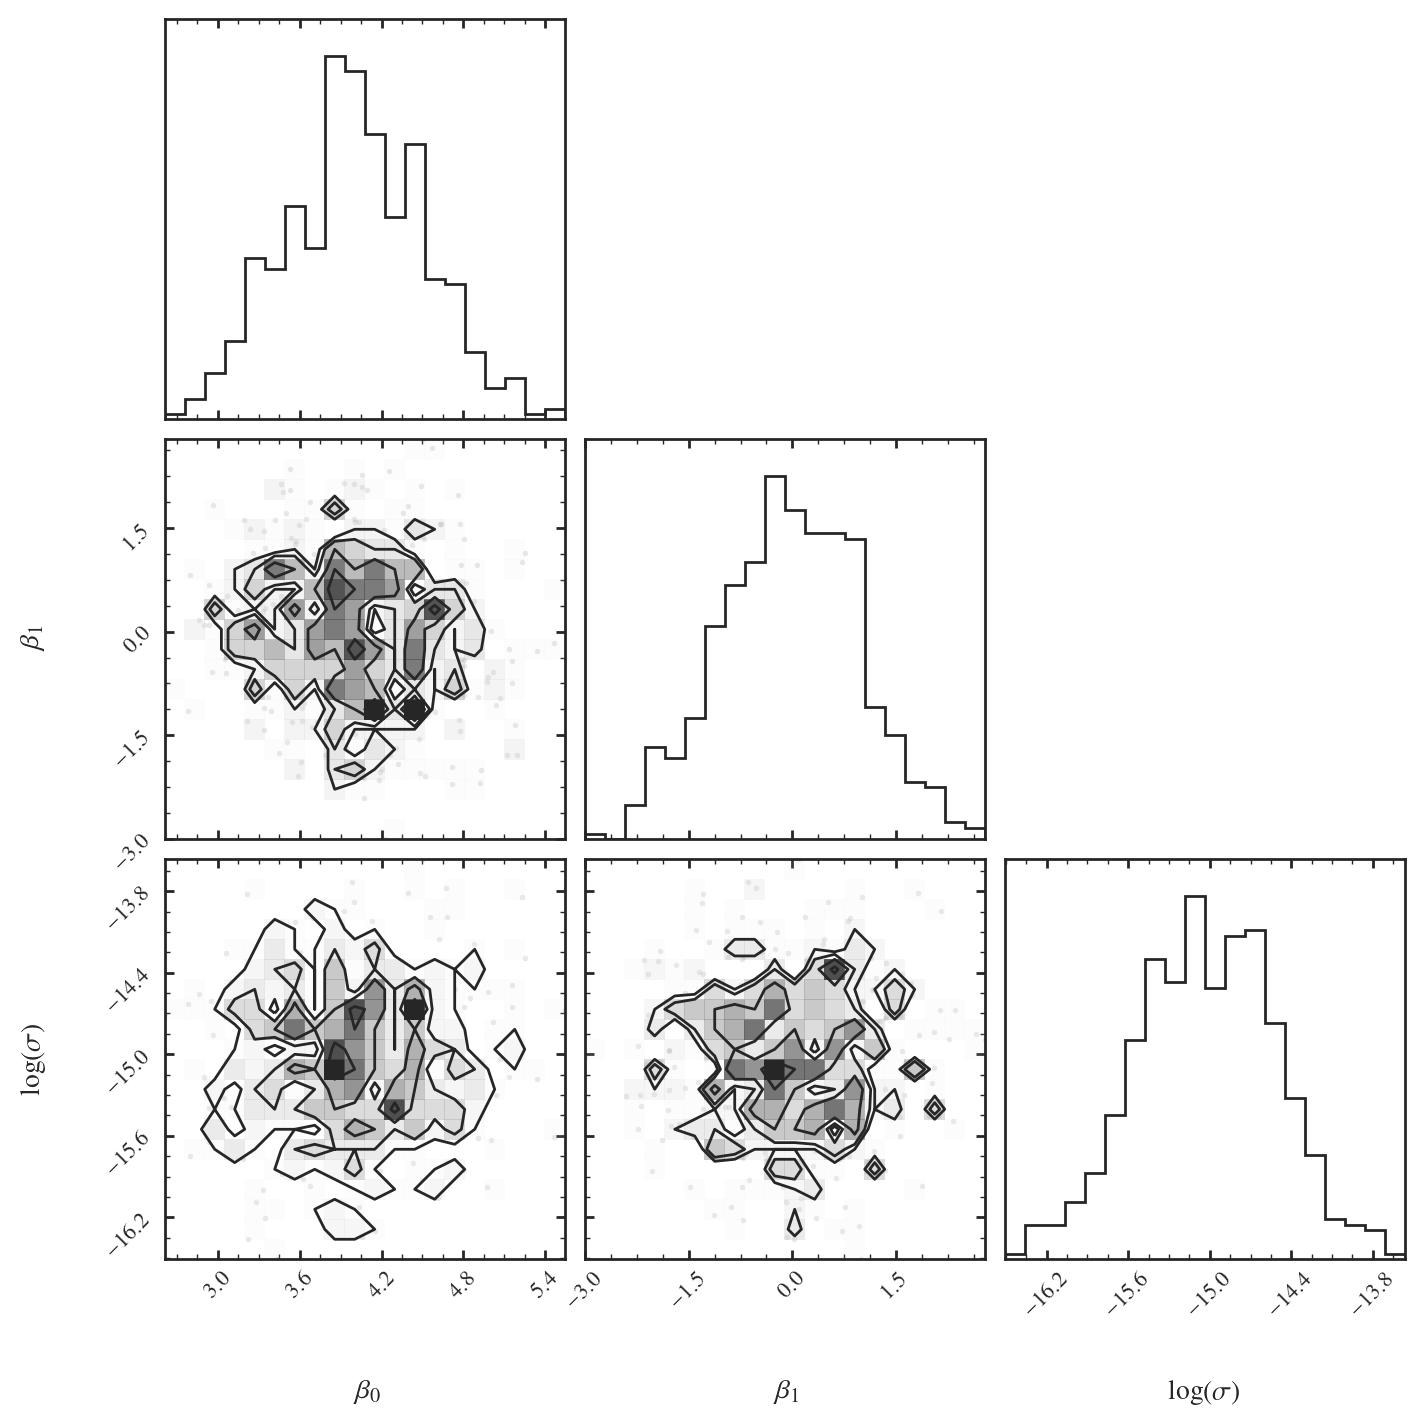

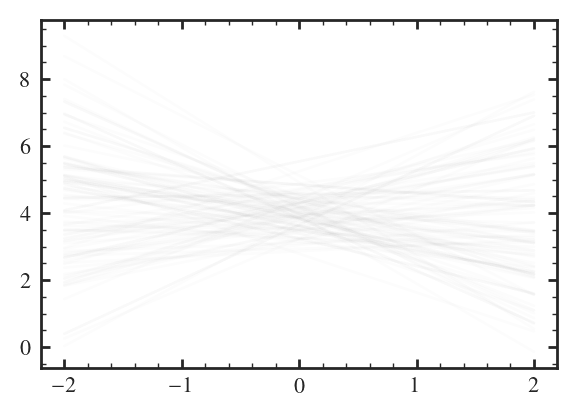

In [37]:
mcmc_utils.plot_prior(model, N=1_000)

100%|██████████| 1000/1000 [00:10<00:00, 93.02it/s]


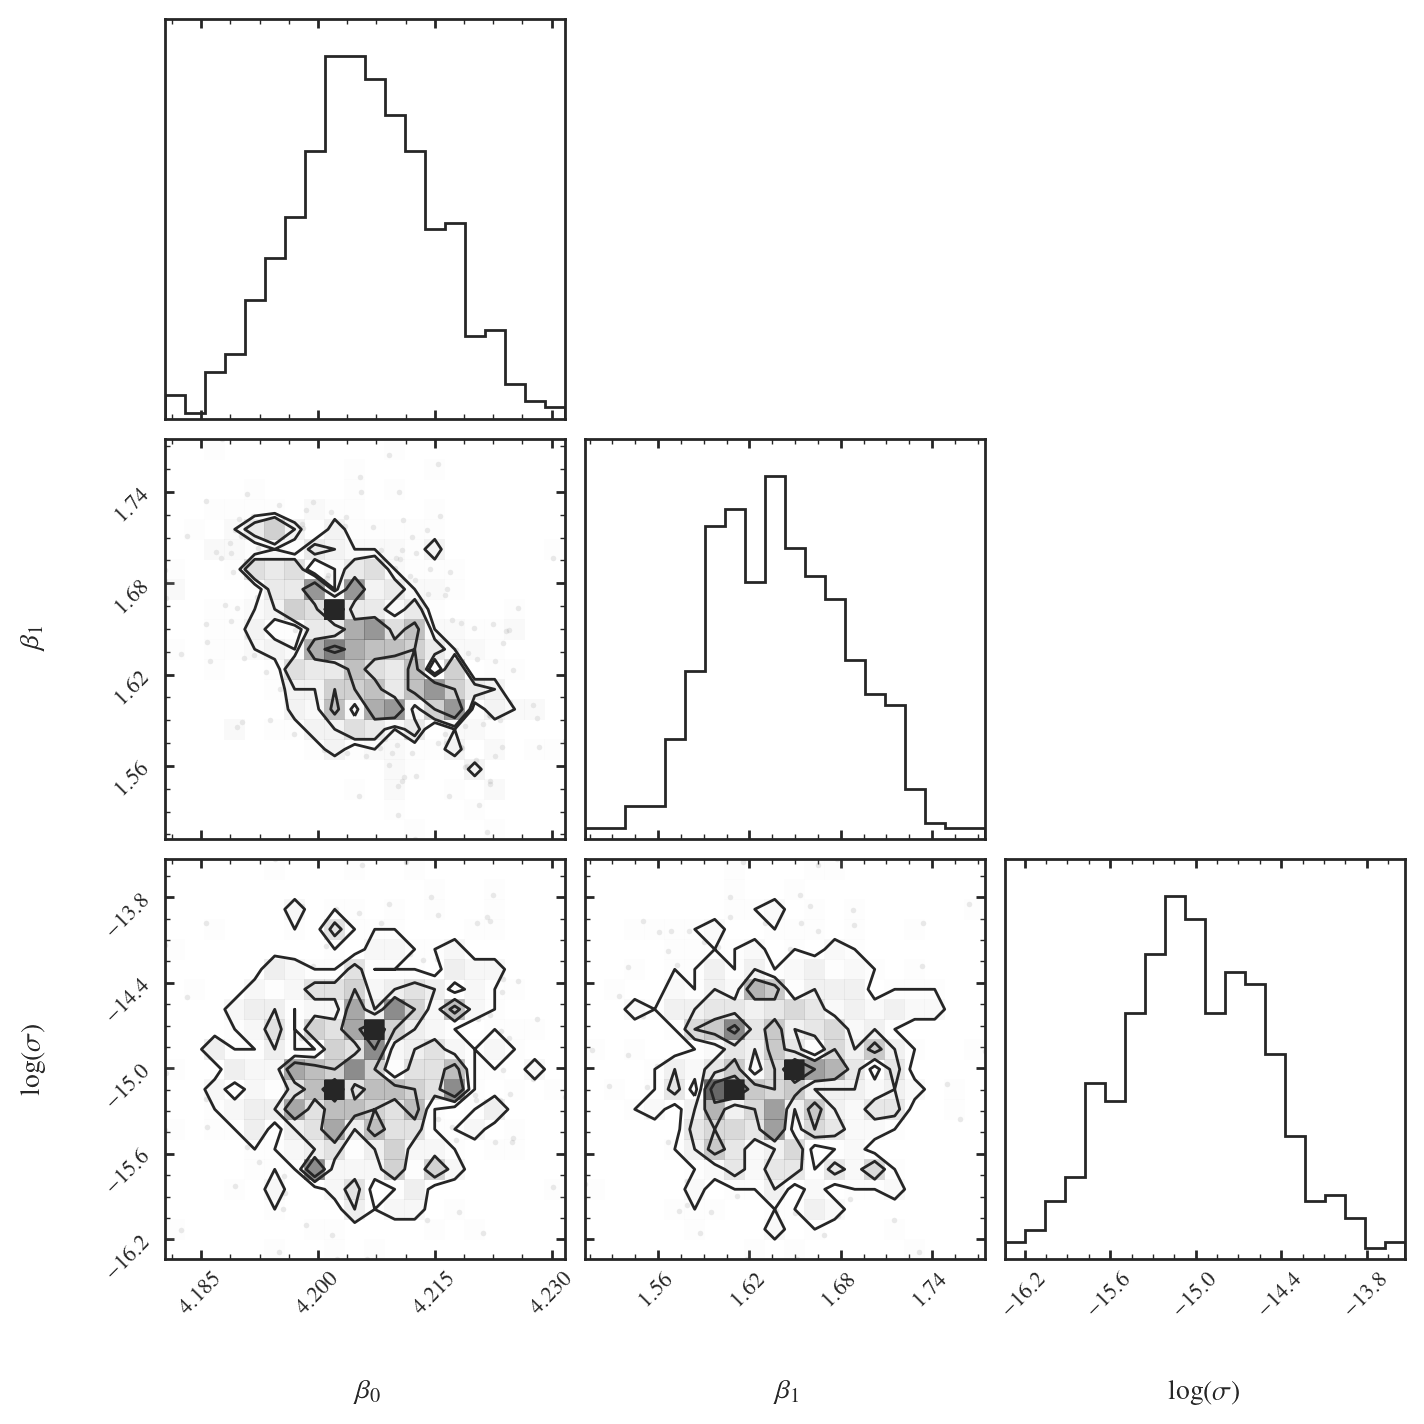

In [38]:
samples = mcmc_utils.run_mcmc(model, obs)

$\beta_0$ = 4.21 + 0.01 - 0.01
$\beta_1$ = 1.64 + 0.04 - 0.05
$\log(\sigma)$ = -15.02 + 0.49 - 0.52


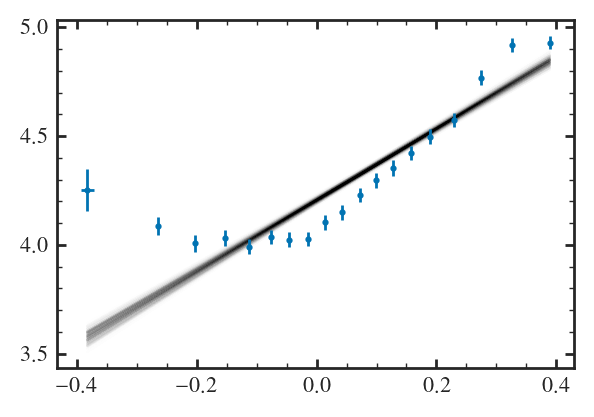

In [39]:
mcmc_utils.plot_posterior(model, obs, samples, N_lines=500)

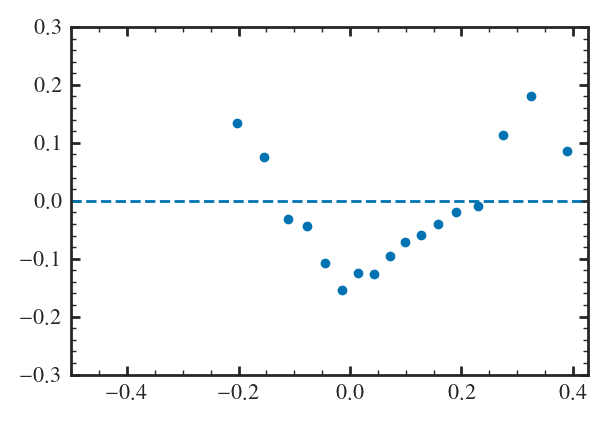

In [40]:
theta_m = np.median(samples, axis=0)
y_pred = model(xm, theta_m)

#plt.scatter(x_obs, y_obs - y_pred, s=2, c=w, ec="none", cmap="Greys", alpha=0.4)
plt.scatter(xm, yym - y_pred, )
plt.ylim(-0.3, 0.3)
plt.xlim(-0.5)
plt.axhline(0, ls="--")

# Exponential model

In [43]:
model  = mcmc_utils.Exponential()

[[-0.97416204 -0.65896266 -0.01270123  1.49971578]
 [-0.22581357 -0.37390339 -0.12677662  1.87924887]
 [ 0.45404909  0.2063629   0.593665   -0.06055444]
 [ 2.08467462 -0.42939375 -2.1531916  -0.98075863]
 [ 0.25546316 -0.66843087 -0.67478388 -1.21951412]
 [-0.43254853 -0.83374933  1.44955814 -0.79621972]
 [ 0.08512258 -1.17843087 -0.24938917  0.72306691]
 [ 0.10387794  0.3336342   0.22241349 -0.42466263]
 [-0.8005855  -1.54472682 -0.46857691 -0.36772597]
 [ 0.44040522  0.37078948  0.29715915  0.23131642]]


100%|██████████| 1000/1000 [00:12<00:00, 82.66it/s]


$\beta_0$ = 0.07 + 1.04 - 0.95
$\beta_1$ = 0.19 + 0.95 - 0.97
$\beta_2$ = -0.03 + 0.89 - 1.02
$\log(\sigma)$ = -0.10 + 1.02 - 1.01


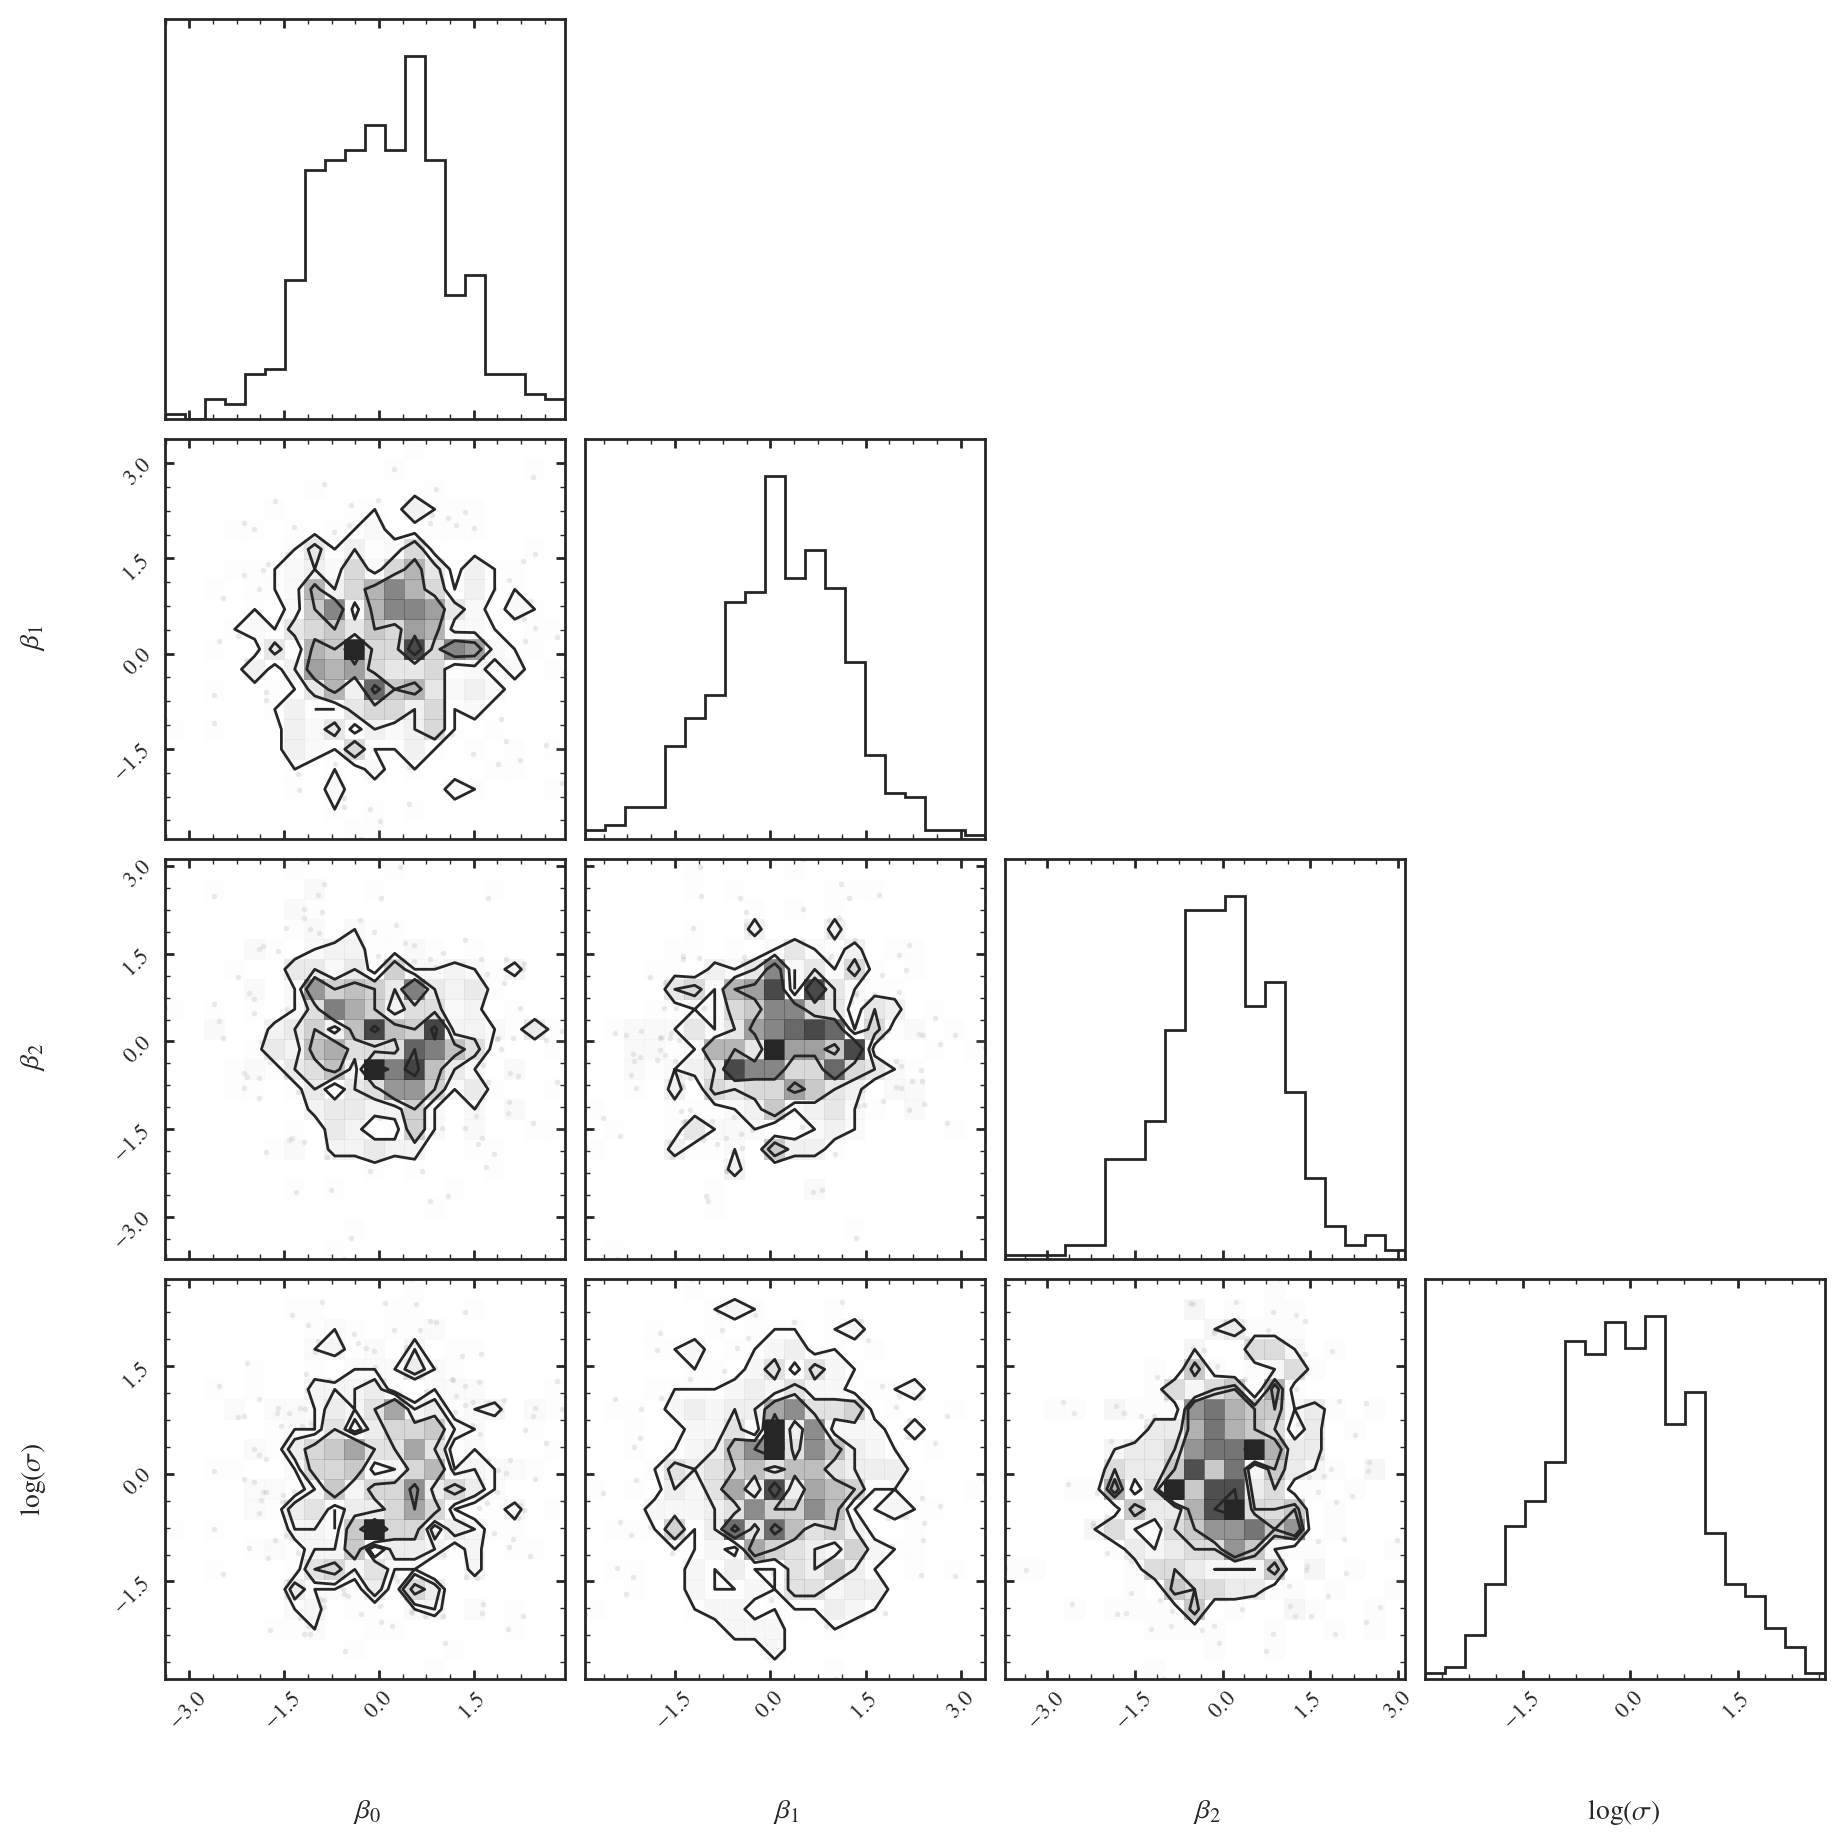

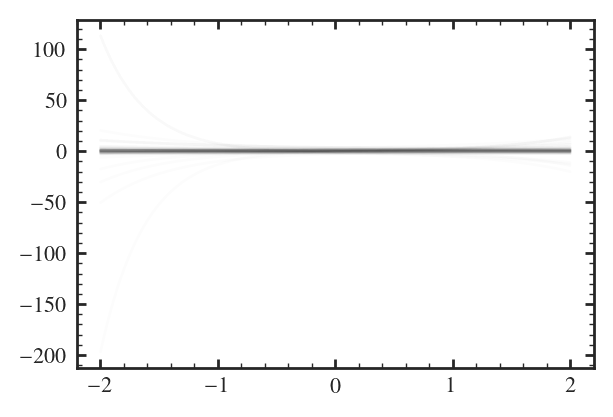

In [44]:
mcmc_utils.plot_prior(model)

100%|██████████| 1000/1000 [00:11<00:00, 85.60it/s]


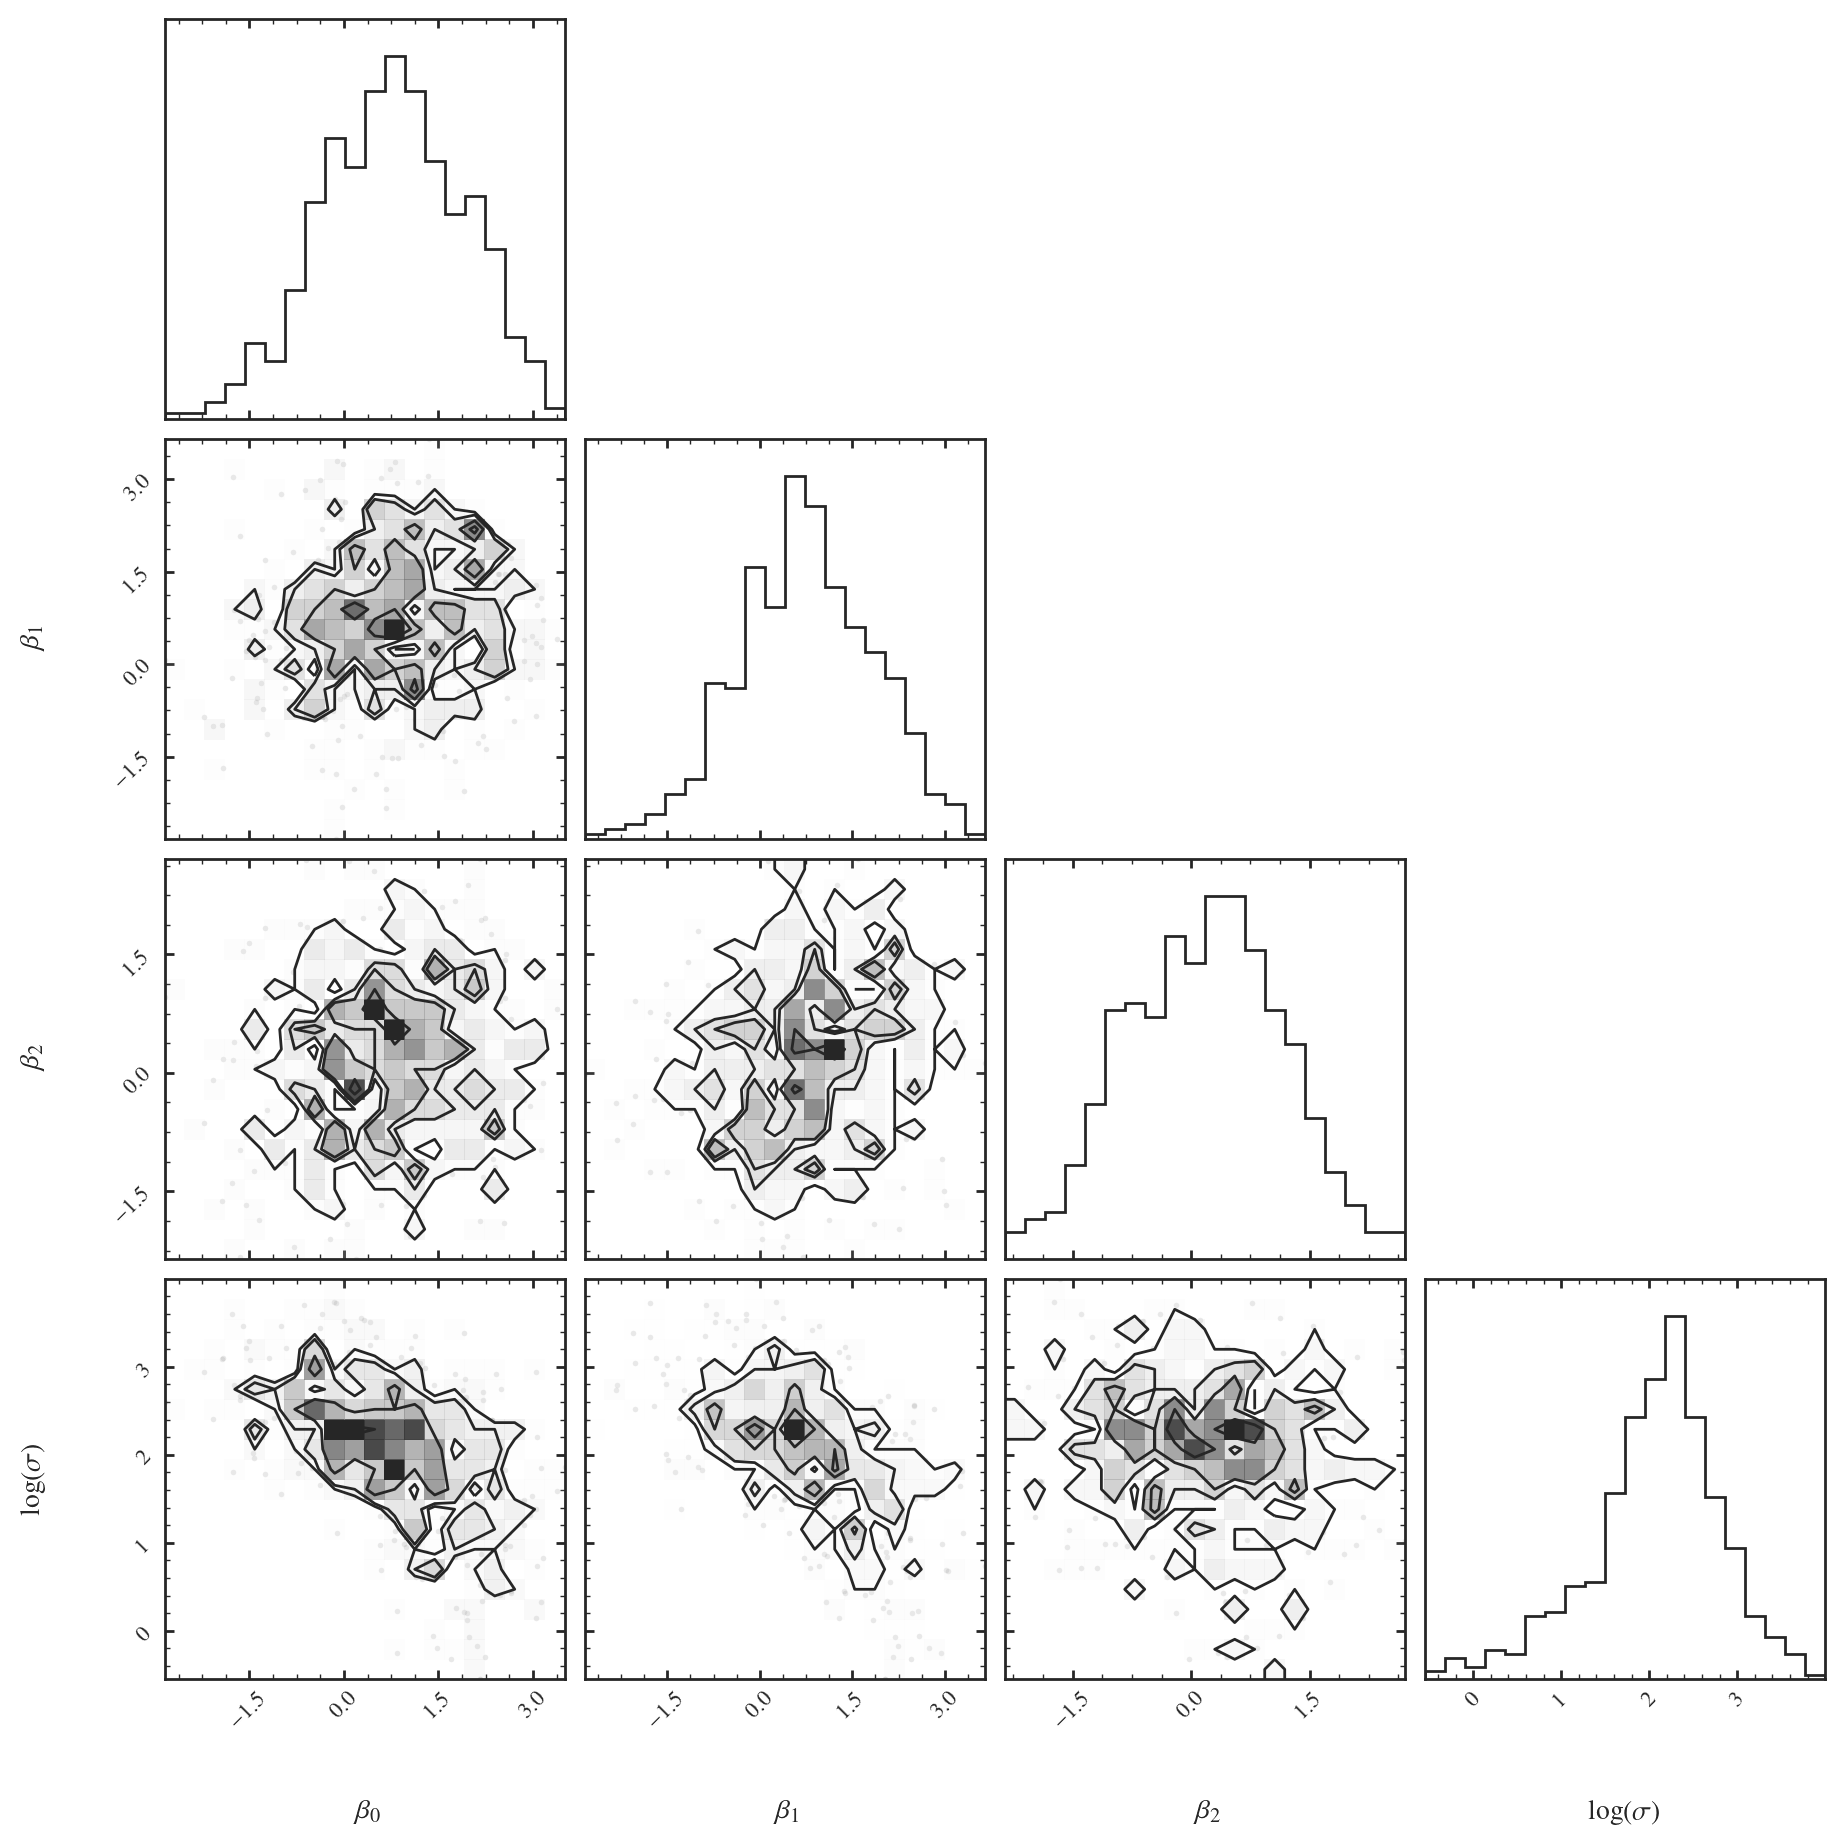

In [45]:
samples = mcmc_utils.run_mcmc(model, obs)

$\beta_0$ = 0.79 + 1.14 - 1.18
$\beta_1$ = 0.73 + 1.06 - 1.15
$\beta_2$ = 0.21 + 1.08 - 0.94
$\log(\sigma)$ = 2.16 + 0.80 - 0.58


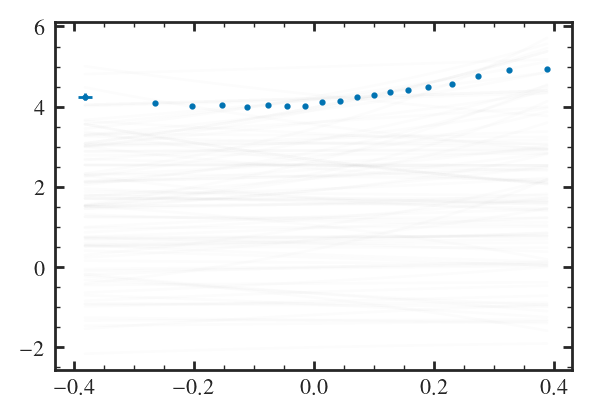

In [46]:
mcmc_utils.plot_posterior(model, obs, samples)

## Quadratic model

In [47]:
model  = mcmc_utils.Quadratic()

In [ ]:
mcmc_utils.plot_prior(model)

[[ 0.4454041  -1.95109473  0.21086517  1.43514403]
 [-0.27810364  0.29779806  1.58109241  1.2274766 ]
 [-0.61057022 -0.2606504  -0.41015294 -0.36330645]
 [-1.36314667  0.36106082 -0.58959178 -0.13540643]
 [ 1.7042988  -1.15031795  1.02369224  0.69814715]
 [ 0.02359358  1.11293315  0.13933586 -1.32620244]
 [ 2.0355877  -0.20785864 -0.03894063  0.56383546]
 [ 1.12332372 -0.70513693  0.23531859 -2.016745  ]
 [ 1.69488395 -1.54935476  0.41268176 -0.90984539]
 [-0.23540367  0.37172255 -0.14180334 -0.44358347]]


 42%|████▏     | 422/1000 [00:04<00:06, 89.79it/s]

In [ ]:
samples = mcmc_utils.run_mcmc(model, obs)

In [ ]:
mcmc_utils.plot_posterior(model, obs, samples)